In [7]:

# Full Jupyter-ready Python code implementing Decision Tree + KNN with Big Data concepts simulated in pure Python.
# It will:
# - Simulate HDFS zones (raw, processed, analytics)
# - Read the Telco CSV in chunks (chunk-based processing)
# - Clean data and convert TotalCharges
# - MapReduce-style aggregation (churn counts by Contract)
# - Sharding & replication (by tenure_bin)
# - KV-store and materialized view simulation
# - Parallel preprocessing using concurrent.futures
# - Build ML pipeline: OneHotEncoder + StandardScaler + models (DecisionTree, KNN)
# - Train, evaluate, save models
# - Streaming simulation: run model predictions on mini-batches and save results
# - Save summary CSVs and models for download
#
# Note: This code assumes the dataset is at /mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv
# Run this whole cell in a Jupyter Notebook (it will produce outputs and save files under /mnt/data/bigdata_demo/).


In [8]:
# ============================================================
# COMPLETE UPDATED JUPYTER NOTEBOOK CODE
# - Big Data concept simulation (HDFS zones, chunked processing, MapReduce, sharding/replication)
# - NoSQL simulation (KV store, materialized view)
# - Safe "parallel" simulation (no multiprocessing)
# - FULL preprocessing + visualization block
# - Feature engineering
# - Decision Tree + KNN training & evaluation
# - Windows/Jupyter safe, no multiprocessing issues, NaN-safe
# - Saves artifacts under /mnt/data/bigdata_demo/analytics_zone
# ============================================================

import os
import shutil
from pathlib import Path
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


In [9]:
# ============================================================
# 0. Setup simulated HDFS zones and copy raw file
# ============================================================

BASE = Path("/mnt/data/bigdata_demo")
RAW = BASE / "raw_zone"
PROCESSED = BASE / "processed_zone"
ANALYTICS = BASE / "analytics_zone"
SHARDS = BASE / "shards"
REPLICAS = BASE / "replicas"

for p in [RAW, PROCESSED, ANALYTICS, SHARDS, REPLICAS]:
    p.mkdir(parents=True, exist_ok=True)

src = Path("/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
raw_copy = RAW / src.name
if not raw_copy.exists():
    shutil.copy(src, raw_copy)

print("Raw file copied to:", raw_copy)


Raw file copied to: \mnt\data\bigdata_demo\raw_zone\WA_Fn-UseC_-Telco-Customer-Churn.csv


In [10]:
# ============================================================
# 1. Chunk-based cleaning (simulate big-data ingestion & map step)
# ============================================================

processed_file = PROCESSED / "telco_processed.csv"
if processed_file.exists():
    processed_file.unlink()

chunk_size = 5000

def clean_chunk(df):
    # convert TotalCharges to numeric
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')
    # strip whitespace
    obj_cols = df.select_dtypes(include='object').columns.tolist()
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()
    return df

map_results = []
reader = pd.read_csv(raw_copy, chunksize=chunk_size)
for i, chunk in enumerate(reader, 1):
    c = clean_chunk(chunk)
    header = not processed_file.exists()
    c.to_csv(processed_file, mode='a', index=False, header=header)

    # map aggregation: churn counts by Contract
    if 'Contract' in c.columns and 'Churn' in c.columns:
        map_results.append(c.groupby('Contract')['Churn'].value_counts().unstack(fill_value=0))

    print(f"Processed chunk {i}, rows: {len(c)}")

# ============================================================
# 2. Reduce step (aggregate chunk-level results)
# ============================================================

if map_results:
    reduce_df = pd.concat(map_results).groupby(level=0).sum()
    reduce_df = reduce_df.rename_axis(index='Contract').reset_index()
    reduce_df.to_csv(ANALYTICS / "churn_counts_by_contract_mapreduce.csv", index=False)
    print("MapReduce preview (churn by contract):")
    display(reduce_df)


Processed chunk 1, rows: 5000
Processed chunk 2, rows: 2043
MapReduce preview (churn by contract):


Churn,Contract,No,Yes
0,Month-to-month,2220,1655
1,One year,1307,166
2,Two year,1647,48


In [11]:

# ============================================================
# 3. Load processed dataset
# ============================================================

df = pd.read_csv(processed_file)
print("Processed dataset shape:", df.shape)
display(df.head())


Processed dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  70

None


Missing values (descending):


TotalCharges    11
dtype: int64

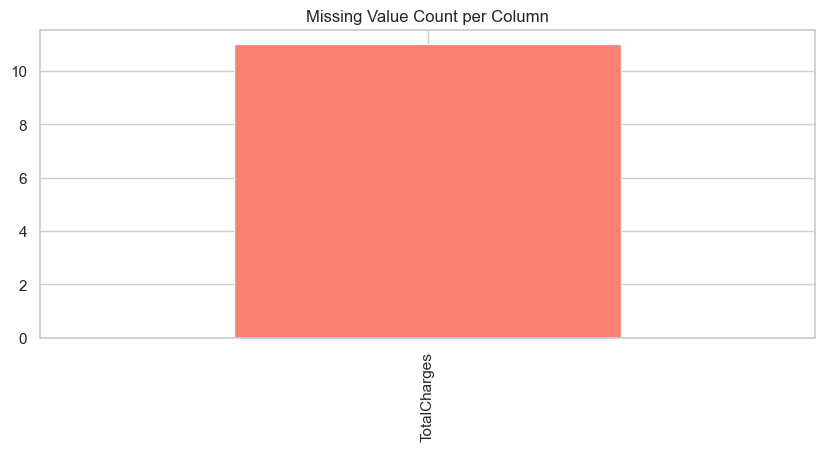

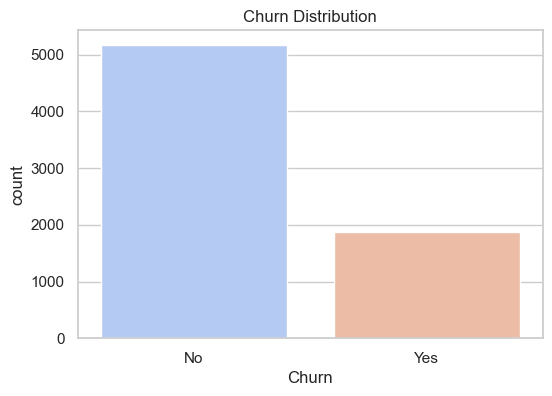

Churn value counts (%)


No     73.46
Yes    26.54
Name: Churn, dtype: float64

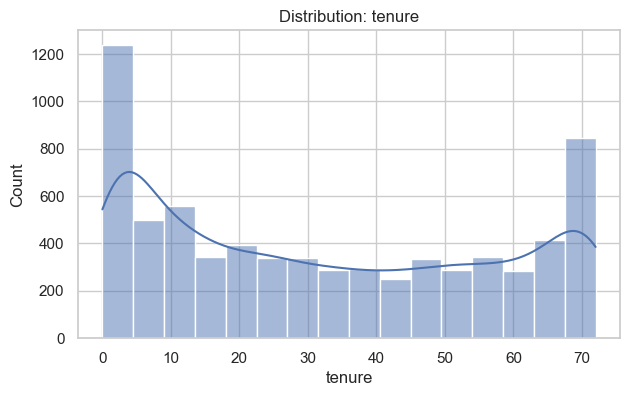

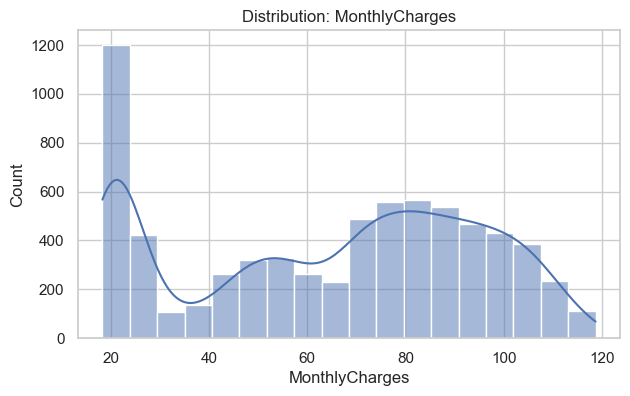

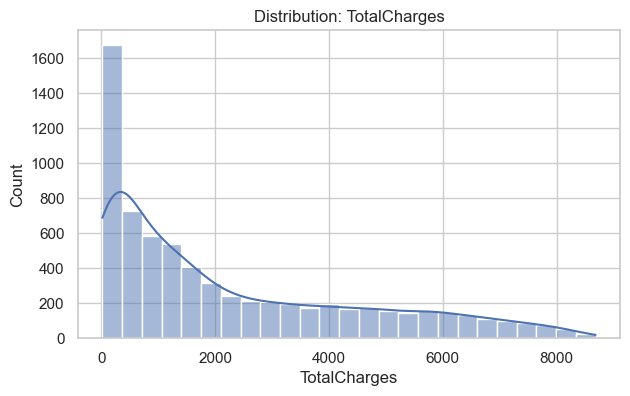

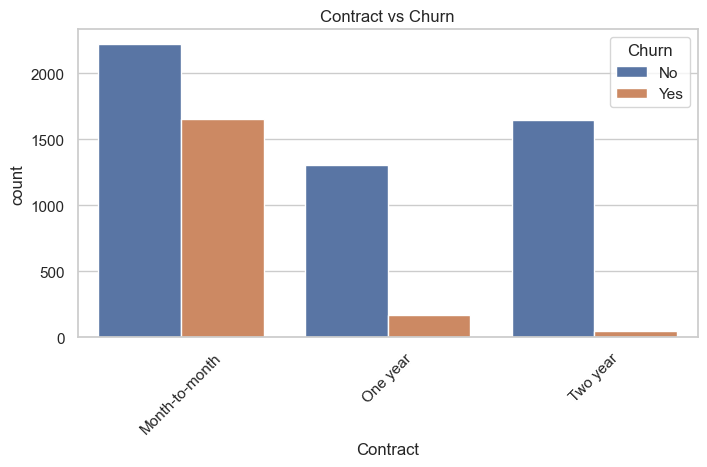

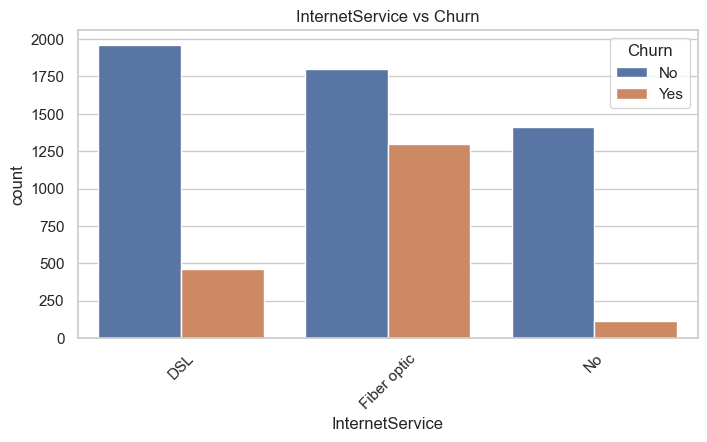

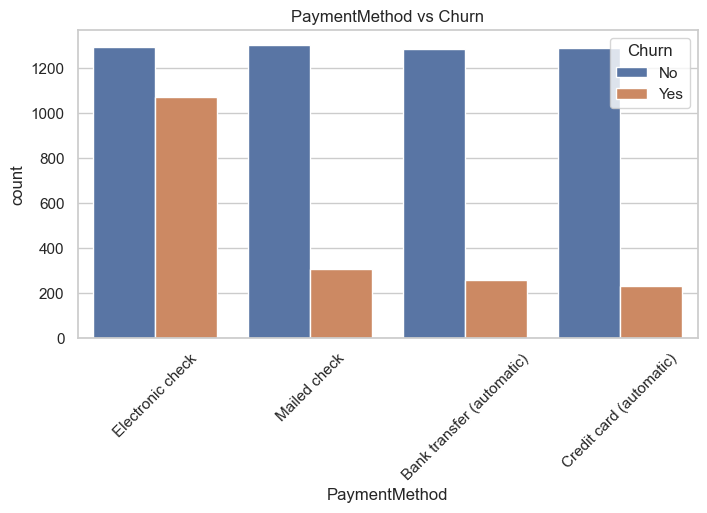

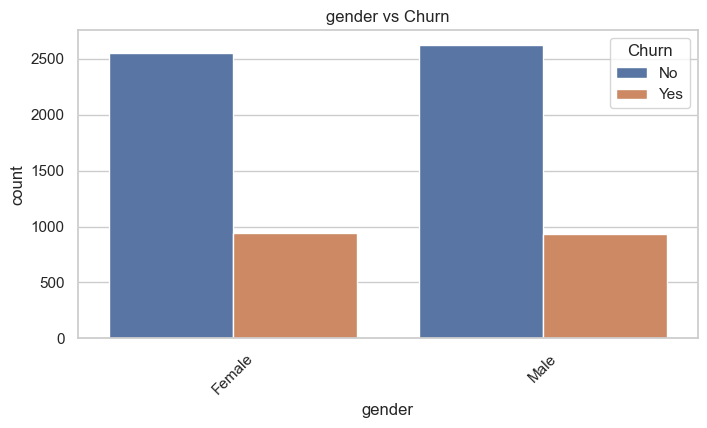

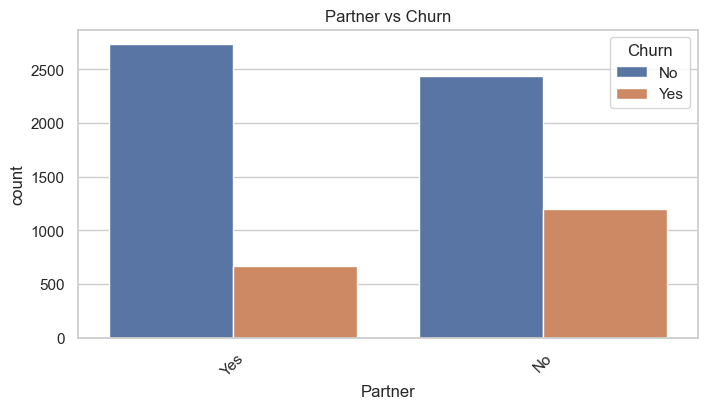

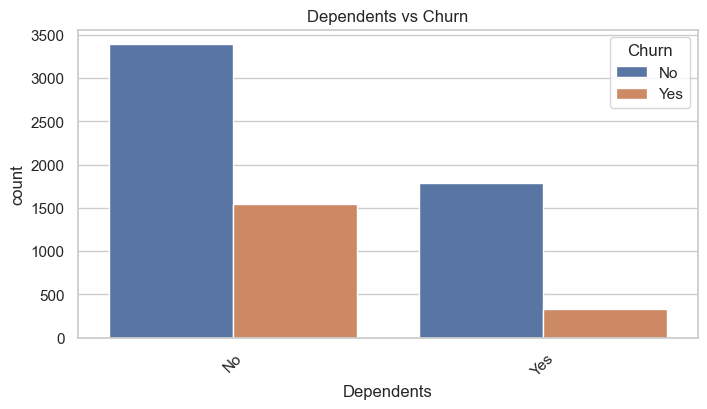

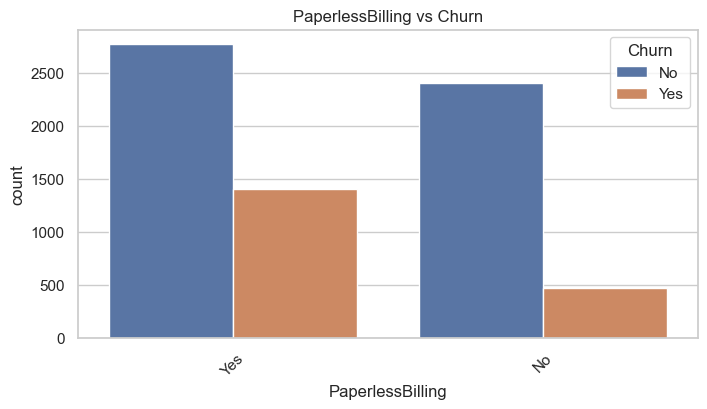

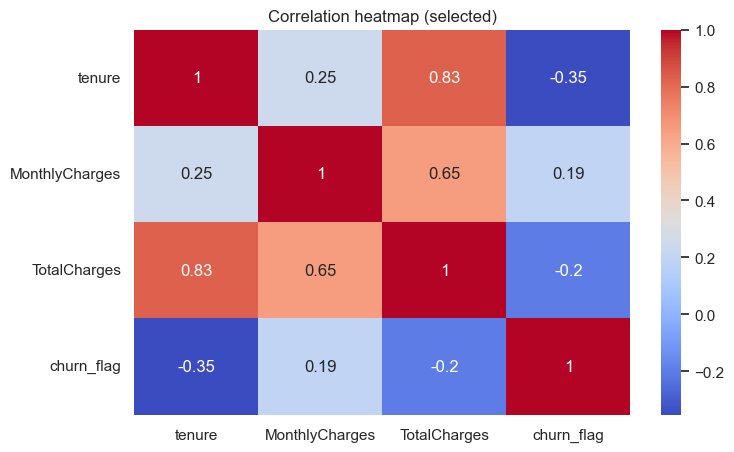

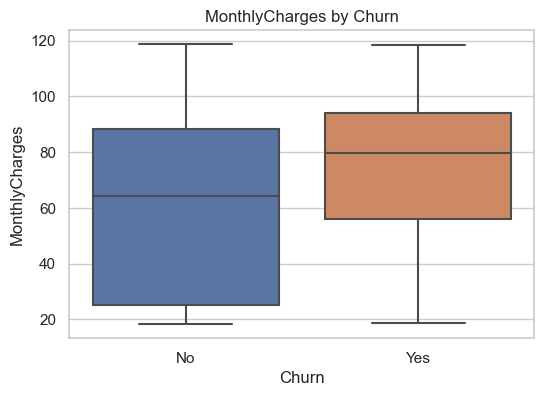

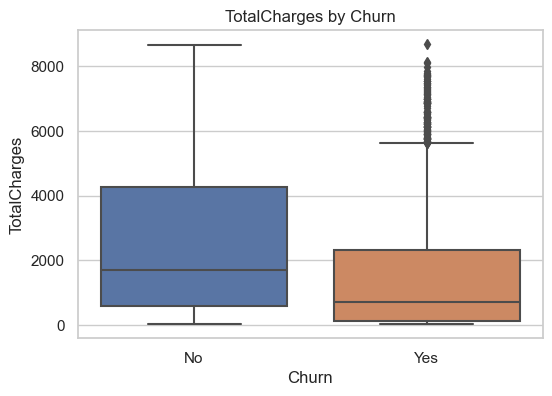


Before/After shape (outlier removal demo): (7043, 21) -> (7032, 21)


In [12]:

# ============================================================
# 4. EXTRA PREPROCESSING + VISUALIZATION (before feature-engineering)
#    - missing values, distributions, categorical counts, corr heatmap, outliers
# ============================================================

# Basic info
print("\n=== Dataset Info ===")
display(df.info())

# 4.1 Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (descending):")
display(missing[missing > 0])

if (missing > 0).any():
    plt.figure(figsize=(10,4))
    missing[missing>0].plot(kind='bar', color='salmon')
    plt.title("Missing Value Count per Column")
    plt.show()

# 4.2 Churn distribution
if 'Churn' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x='Churn', palette="coolwarm")
    plt.title("Churn Distribution")
    plt.show()
    print("Churn value counts (%)")
    display(df['Churn'].value_counts(normalize=True).mul(100).round(2))

# 4.3 Numerical distributions
num_cols = [c for c in ['tenure','MonthlyCharges','TotalCharges'] if c in df.columns]
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution: {col}")
    plt.show()

# 4.4 Categorical countplots (selected columns)
cat_cols = [c for c in ['Contract','InternetService','PaymentMethod','gender','Partner','Dependents','PaperlessBilling'] if c in df.columns]
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Churn")
    plt.show()

# 4.5 Correlation heatmap (numeric + churn flag)
corr_df = df.copy()
if 'Churn' in corr_df.columns:
    corr_df['churn_flag'] = corr_df['Churn'].map({'Yes':1,'No':0})
heat_cols = [c for c in ['tenure','MonthlyCharges','TotalCharges','churn_flag'] if c in corr_df.columns]
if len(heat_cols) >= 2:
    plt.figure(figsize=(8,5))
    sns.heatmap(corr_df[heat_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation heatmap (selected)")
    plt.show()

# 4.6 Boxplots for charges by churn
for col in ['MonthlyCharges','TotalCharges']:
    if col in df.columns and 'Churn' in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x='Churn', y=col)
        plt.title(f"{col} by Churn")
        plt.show()

# 4.7 Outlier detection using IQR (demonstration) & record counts before/after
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df_outlier_demo = df.copy()
for col in num_cols:
    df_outlier_demo = remove_outliers_iqr(df_outlier_demo, col)
print("\nBefore/After shape (outlier removal demo):", df.shape, "->", df_outlier_demo.shape)

In [14]:
# 5. Feature Engineering (tenure bins, churn_flag, num_services)
# ============================================================

def add_features(df):
    df = df.copy()
    # Tenure binning
    if 'tenure' in df.columns:
        bins = [0,1,6,12,24,36,48,60,1000]
        labels = ['0','1-6','7-12','13-24','25-36','37-48','49-60','61+']
        df['tenure_bin'] = pd.cut(df['tenure'], bins=bins, labels=labels)
    # churn flag
    if 'Churn' in df.columns:
        df['churn_flag'] = df['Churn'].map({'Yes':1,'No':0})
    # service count
    service_cols = [c for c in ['PhoneService','InternetService','OnlineSecurity','OnlineBackup',
                                'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'] if c in df.columns]
    if service_cols:
        df['num_services'] = df[service_cols].apply(lambda r: sum(r == 'Yes'), axis=1)
    return df

df = add_features(df)
display(df[['customerID','tenure','tenure_bin','MonthlyCharges','TotalCharges','num_services']].head())


,customerID,tenure,tenure_bin,MonthlyCharges,TotalCharges,num_services
0,7590-VHVEG,1,0,29.85,29.85,1
1,5575-GNVDE,34,25-36,56.95,1889.50,3
2,3668-QPYBK,2,1-6,53.85,108.15,3
3,7795-CFOCW,45,37-48,42.30,1840.75,3
4,9237-HQITU,2,1-6,70.70,151.65,1


In [15]:
# ============================================================

# ============================================================
# 6. Sharding & replication simulation
# ============================================================

shard_paths = []
if 'tenure_bin' in df.columns:
    for label in df['tenure_bin'].dropna().unique():
        shard_df = df[df['tenure_bin'] == label]
        shard_file = SHARDS / f"shard_tenure_{label}.csv"
        shard_df.to_csv(shard_file, index=False)
        shard_paths.append(shard_file)
        # two replicas
        for r in range(2):
            rep_dir = REPLICAS / f"replica_{r+1}"
            rep_dir.mkdir(parents=True, exist_ok=True)
            shutil.copy(shard_file, rep_dir / shard_file.name)
print("Shards created:", len(shard_paths))

Shards created: 8


In [16]:
# ============================================================
# 7. KV-store sample + materialized view (NoSQL simulation)
# ============================================================

kv_store = {}
for idx, row in df.head(300).iterrows():
    kv_store[row['customerID']] = {
        'tenure': row.get('tenure', None),
        'MonthlyCharges': row.get('MonthlyCharges', None),
        'TotalCharges': row.get('TotalCharges', None),
        'churn_flag': row.get('churn_flag', None)
    }
with open(ANALYTICS / "kv_store_sample.json", "w") as f:
    json.dump(kv_store, f, indent=2, default=str)

if 'Contract' in df.columns and 'churn_flag' in df.columns:
    mat_view = df.groupby('Contract')['churn_flag'].mean().reset_index().rename(columns={'churn_flag':'churn_rate'})
    mat_view.to_csv(ANALYTICS / "materialized_view_churn_rate_by_contract.csv", index=False)
    display(mat_view)

,Contract,churn_rate
0,Month-to-month,0.427097
1,One year,0.112695
2,Two year,0.028319


In [17]:
# ============================================================
# 8. Safe "parallel" simulation (no multiprocessing)
# ============================================================

def compute_num_services_part(sub_df):
    svc_cols = [c for c in ['PhoneService','InternetService','OnlineSecurity','OnlineBackup',
                            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies'] if c in sub_df.columns]
    sub_df = sub_df.copy()
    if svc_cols:
        sub_df['num_services_calc'] = sub_df[svc_cols].apply(lambda r: sum(r == 'Yes'), axis=1)
    else:
        sub_df['num_services_calc'] = 0
    return sub_df[['customerID','num_services_calc']]

parts = np.array_split(df, 4)
results = [compute_num_services_part(p) for p in parts]
parallel_df = pd.concat(results)
parallel_df.to_csv(ANALYTICS / "parallel_num_services.csv", index=False)
display(parallel_df.head())


,customerID,num_services_calc
0,7590-VHVEG,1
1,5575-GNVDE,3
2,3668-QPYBK,3
3,7795-CFOCW,3
4,9237-HQITU,1


In [18]:
# ============================================================
# 9. Prepare ML dataset: select features, fix NaNs, encoding safety
# ============================================================

features = [
    'gender','SeniorCitizen','Partner','Dependents','tenure','MonthlyCharges',
    'TotalCharges','Contract','PaymentMethod','InternetService','OnlineSecurity',
    'TechSupport','num_services'
]
features = [f for f in features if f in df.columns]
target = 'churn_flag'

ml_df = df[features + [target]].copy()

# Fix NaNs: numerical → median, categorical → 'Unknown'
num_cols = ml_df.select_dtypes(include=['int64','float64']).columns.tolist()
if target in num_cols:
    num_cols.remove(target)
cat_cols = ml_df.select_dtypes(include=['object']).columns.tolist()

for c in num_cols:
    ml_df[c] = ml_df[c].fillna(ml_df[c].median())

for c in cat_cols:
    ml_df[c] = ml_df[c].fillna("Unknown")

print("\nNaN counts after imputation:")
display(ml_df.isna().sum())

# Save cleaned ML dataset
clean_file = PROCESSED / "telco_clean_preprocessed.csv"
ml_df.to_csv(clean_file, index=False)
print("Saved cleaned ML dataset to:", clean_file)


NaN counts after imputation:


gender             0
SeniorCitizen      0
Partner            0
Dependents         0
tenure             0
MonthlyCharges     0
TotalCharges       0
Contract           0
PaymentMethod      0
InternetService    0
OnlineSecurity     0
TechSupport        0
num_services       0
churn_flag         0
dtype: int64

Saved cleaned ML dataset to: \mnt\data\bigdata_demo\processed_zone\telco_clean_preprocessed.csv


In [19]:
# ============================================================
# 10. Train-test split
# ============================================================

train_df, test_df = train_test_split(ml_df, test_size=0.2, random_state=42, stratify=ml_df[target])
print("Train/Test shapes:", train_df.shape, test_df.shape)

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = [c for c in train_df.select_dtypes(include=['int64','float64']).columns if c != target]

print("Numerical cols:", numerical_cols)
print("Categorical cols:", categorical_cols)


Train/Test shapes: (5634, 14) (1409, 14)
Numerical cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'num_services']
Categorical cols: ['gender', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'TechSupport']


In [21]:
# ============================================================
# 11. Preprocessing pipeline
# ============================================================

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, numerical_cols),
    ('cat', ohe, categorical_cols)
], remainder='drop')


In [23]:
# ============================================================
# 12. Model training & evaluation helpers
# ============================================================

def evaluate_model(pipe, X_test, y_test):
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], 'predict_proba') or True else None
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = None
    try:
        auc = roc_auc_score(y_test, proba)
    except Exception:
        auc = None
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc, 'preds': preds, 'proba': proba}

def train_and_eval(model, name):
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]
    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]
    pipe.fit(X_train, y_train)
    results = evaluate_model(pipe, X_test, y_test)
    print(f"\n=== {name} Results ===")
    print("Accuracy:", round(results['accuracy'],4))
    print("Precision:", round(results['precision'],4))
    print("Recall:", round(results['recall'],4))
    print("F1:", round(results['f1'],4))
    if results['roc_auc'] is not None:
        print("ROC-AUC:", round(results['roc_auc'],4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, results['preds']))
    print("Classification Report:\n", classification_report(y_test, results['preds']))
    joblib.dump(pipe, ANALYTICS / f"{name}_pipeline.joblib")
    return results


In [24]:
# ============================================================
# 13. Train Decision Tree
# ============================================================

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt_results = train_and_eval(dt, "decision_tree")

# Feature importance (map back to names)
try:
    ohe_cols = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    feature_names = numerical_cols + ohe_cols
    fi = dt_results and dt_results.get('preds')  # just to avoid lint issues
    # Refit a pipeline to extract feature importances
    dt_pipe = Pipeline([('pre', preprocessor), ('clf', DecisionTreeClassifier(max_depth=6, random_state=42))])
    dt_pipe.fit(train_df.drop(columns=[target]), train_df[target])
    importances = dt_pipe.named_steps['clf'].feature_importances_
    fi_df = pd.DataFrame({'feature':feature_names, 'importance':importances}).sort_values('importance', ascending=False)
    fi_df.head(20).to_csv(ANALYTICS / "decision_tree_feature_importance.csv", index=False)
    display(fi_df.head(15))
except Exception as e:
    print("Could not extract feature importances:", e)



=== decision_tree Results ===
Accuracy: 0.7892
Precision: 0.6097
Recall: 0.5722
F1: 0.5903
ROC-AUC: 0.8277
Confusion Matrix:
 [[898 137]
 [160 214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1035
           1       0.61      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



,feature,importance
11,Contract_Month-to-month,0.478593
1,tenure,0.157756
19,InternetService_Fiber optic,0.152024
2,MonthlyCharges,0.058354
3,TotalCharges,0.044992
24,TechSupport_No,0.026854
16,PaymentMethod_Electronic check,0.026801
21,OnlineSecurity_No,0.017953
13,Contract_Two year,0.010039
0,SeniorCitizen,0.008044


In [25]:
# ============================================================
# 14. Train KNN (with small grid search demonstration)
# ============================================================

knn = KNeighborsClassifier()
param_grid = {'n_neighbors':[3,5,7]}
gs = GridSearchCV(knn, param_grid, cv=3, scoring='f1', n_jobs=1)
knn_pipe = Pipeline([('pre', preprocessor), ('clf', gs)])
knn_pipe.fit(train_df.drop(columns=[target]), train_df[target])
best_k = knn_pipe.named_steps['clf'].best_params_
print("Best K for KNN:", best_k)
# Evaluate KNN
knn_best_pipe = Pipeline([('pre', preprocessor), ('clf', knn_pipe.named_steps['clf'].best_estimator_)])
knn_best_pipe.fit(train_df.drop(columns=[target]), train_df[target])
knn_results = evaluate_model(knn_best_pipe, test_df.drop(columns=[target]), test_df[target])
print("\n=== KNN Results ===")
print("Accuracy:", round(knn_results['accuracy'],4))
print("Precision:", round(knn_results['precision'],4))
print("Recall:", round(knn_results['recall'],4))
print("F1:", round(knn_results['f1'],4))
if knn_results['roc_auc'] is not None:
    print("ROC-AUC:", round(knn_results['roc_auc'],4))
print("Confusion Matrix:\n", confusion_matrix(test_df[target], knn_results['preds']))
joblib.dump(knn_best_pipe, ANALYTICS / "knn_pipeline.joblib")

Best K for KNN: {'n_neighbors': 7}

=== KNN Results ===
Accuracy: 0.7835
Precision: 0.6082
Recall: 0.5187
F1: 0.5599
ROC-AUC: 0.7961
Confusion Matrix:
 [[910 125]
 [180 194]]


['\\mnt\\data\\bigdata_demo\\analytics_zone\\knn_pipeline.joblib']

In [26]:
# ============================================================
# 15. Save evaluation summary & artifacts list
# ============================================================

summary = pd.DataFrame([
    {'model':'decision_tree', **{k:v for k,v in dt_results.items() if k in ['accuracy','precision','recall','f1','roc_auc']}},
    {'model':'knn', **{k:v for k,v in knn_results.items() if k in ['accuracy','precision','recall','f1','roc_auc']}}
])
summary.to_csv(ANALYTICS / "model_evaluation_summary.csv", index=False)
print("\nSaved model evaluation summary to:", ANALYTICS / "model_evaluation_summary.csv")

print("\nArtifacts saved in:", ANALYTICS)
for a in sorted(ANALYTICS.glob("*")):
    print("-", a.name)



Saved model evaluation summary to: \mnt\data\bigdata_demo\analytics_zone\model_evaluation_summary.csv

Artifacts saved in: \mnt\data\bigdata_demo\analytics_zone
- churn_counts_by_contract_mapreduce.csv
- decision_tree_feature_importance.csv
- decision_tree_pipeline.joblib
- DecisionTree.joblib
- KNN.joblib
- knn_pipeline.joblib
- kv_store_sample.json
- materialized_view_churn_rate_by_contract.csv
- model_evaluation_summary.csv
- model_results_summary.csv
- parallel_num_services.csv
- streaming_predictions.csv


In [27]:
# ============================================================
# 16. Streaming simulation: predict on mini-batches and append predictions
# ============================================================

stream_preds_file = ANALYTICS / "streaming_predictions.csv"
if stream_preds_file.exists():
    stream_preds_file.unlink()

stream_reader = pd.read_csv(raw_copy, chunksize=1000)
total = 0
for chunk in stream_reader:
    c = clean_chunk(chunk)
    c = add_features(c)
    incoming = c[features].copy()
    # impute missing values same as training
    for col in numerical_cols:
        if col in incoming.columns:
            incoming[col] = pd.to_numeric(incoming[col], errors='coerce').fillna(ml_df[col].median())
    for col in categorical_cols:
        if col in incoming.columns:
            incoming[col] = incoming[col].fillna("Unknown")
    try:
        probs = dt_pipe.predict_proba(incoming)[:,1]
        preds = dt_pipe.predict(incoming)
    except Exception:
        probs = knn_best_pipe.predict_proba(incoming)[:,1]
        preds = knn_best_pipe.predict(incoming)
    out = pd.DataFrame({
        'customerID': c['customerID'] if 'customerID' in c.columns else np.arange(len(incoming)),
        'pred_proba': probs,
        'pred_label': preds
    })
    header = not stream_preds_file.exists()
    out.to_csv(stream_preds_file, mode='a', index=False, header=header)
    total += len(out)
print("Streaming simulation complete. Rows predicted:", total)
print("Streaming preds saved to:", stream_preds_file)

# ============================================================
# END
# ============================================================


Streaming simulation complete. Rows predicted: 7043
Streaming preds saved to: \mnt\data\bigdata_demo\analytics_zone\streaming_predictions.csv
